In [1]:
%pip install pyulog


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Run the ulog2csv tool as a shell command from the notebook.
# Use forward slashes to avoid Python backslash escape issues.
!ulog2csv "C:/Users/12162/Downloads/Drone LOG.ulg"


In [3]:
!dir   # on Windows


 Volume in drive C is OS
 Volume Serial Number is E0BB-A2CA

 Directory of c:\Users\12162\Documents


 Directory of c:\Users\12162\Documents


 Directory of c:\Users\12162\Documents



File Not Found


In [4]:
import os

# List files in current working directory
os.listdir()


['Arduino',
 'BG_SSR_TSRPT.pdf',
 'conda',
 'Corrected Signed Student Affidavit of Eligibility II.pdf',
 'Corrected Signed Student Affidavit of Eligibility.pdf',
 'Cover Letter Research Opportunity.docx',
 'CSV files (1).zip',
 'Custom Office Templates',
 'Data Preparation_LivingDon-2022-RedoUD.ipynb',
 'data_prep_living-checkpoint.ipynb',
 'DB Schema (1).zip',
 'Delaney.cpp',
 'Delaney1.cpp',
 'DelaneyK_Pgm3.zip',
 'DelaneyK_Pgm4.zip',
 'desktop.ini',
 'Drone anomoly detection.ipynb',
 'Enrollment Verification Print.pdf',
 'Highrise Studio',
 'Homework 1 Data Mining (Completed).docx',
 'Homework 2. Data Mining',
 'Homework 2.Data Mining.ipynb',
 'Homework 3 Data Mining.docx',
 'Homework 4.docx',
 'Homework 5 data Mining.docx',
 'HW 4.docx',
 'Introduction.to.Algorithms.4th.Leiserson.Stein.Rivest.Cormen.MIT.Press.9780262046305.EBooksWorld.ir.pdf',
 'Journals',
 'Kaplan curve.png',
 'KDelaneyProject3.zip',
 'KE Files.zip',
 'Kidney_Exchange__Explainable_AI__and_Survival_Analysis (5).pdf

In [5]:
!ulog2csv "C:/Users/12162/Downloads/Drone LOG.ulg"

In [6]:
import os
from pathlib import Path

data_dir = Path("C:/Users/12162/Downloads")
print(data_dir)
print(os.listdir(data_dir))


C:\Users\12162\Downloads
['.ipynb_checkpoints', '0_DataPreparation.ipynb', '1-s2.0-S2468227623003356-main.pdf', '10.1038_s41598-024-66976-0-citation.ris', '144-Dept_.pdf', '1st Schematic.pdf', '2017_Inter-Club Kidney Exchange (1).pdf', '2017_Inter-Club Kidney Exchange (2).pdf', '2017_Inter-Club Kidney Exchange (3).pdf', '2017_Inter-Club Kidney Exchange.pdf', '2018_Multiple Willing Donors and Organ Clubs in Kidney Exchange (1).pdf', '2018_Multiple Willing Donors and Organ Clubs in Kidney Exchange.pdf', '2021_02_NEJ_Notebook.html', '2021_02_NEJ_Notebook.ipynb', '2021_Kidney Exchange_An Operations Perspective.pdf', '2023_06_09_Rematching_Data_Prep.ipynb', '2024_A machine learning approach towards assessing consistency and reproducibility- an application to graft survival across three kidney transplantation eras.pdf', '2024_Deceased-Donor Kidney Transplant Outcome Prediction Using Artificial Intelligence to Aid Decision-Making in Kidney Allocation.pdf', '2024_Enhancing Survival Analysis Mo

Attitude columns: ['timestamp', 'timestamp_sample', 'q[0]', 'q[1]', 'q[2]', 'q[3]', 'delta_q_reset[0]', 'delta_q_reset[1]', 'delta_q_reset[2]', 'delta_q_reset[3]', 'quat_reset_counter']
Local position columns: ['timestamp', 'timestamp_sample', 'ref_timestamp', 'ref_lat', 'ref_lon', 'x', 'y', 'z', 'delta_xy[0]', 'delta_xy[1]', 'delta_z', 'vx', 'vy', 'vz', 'z_deriv', 'delta_vxy[0]', 'delta_vxy[1]', 'delta_vz', 'ax', 'ay', 'az', 'heading', 'delta_heading', 'ref_alt', 'dist_bottom', 'eph', 'epv', 'evh', 'evv', 'vxy_max', 'vz_max', 'hagl_min', 'hagl_max', 'xy_valid', 'z_valid', 'v_xy_valid', 'v_z_valid', 'xy_reset_counter', 'z_reset_counter', 'vxy_reset_counter', 'vz_reset_counter', 'heading_reset_counter', 'heading_good_for_control', 'xy_global', 'z_global', 'dist_bottom_valid', 'dist_bottom_sensor_bitfield', 'dead_reckoning']
Merged shape: (1255, 10)
            t      roll     pitch       yaw         x         y         z  \
0  228.269023 -0.064731 -0.016245 -0.130818 -1.460316 -0.742395

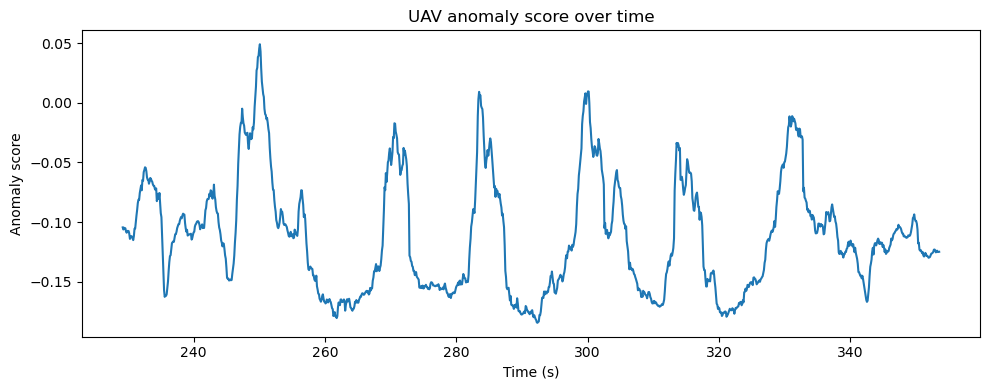

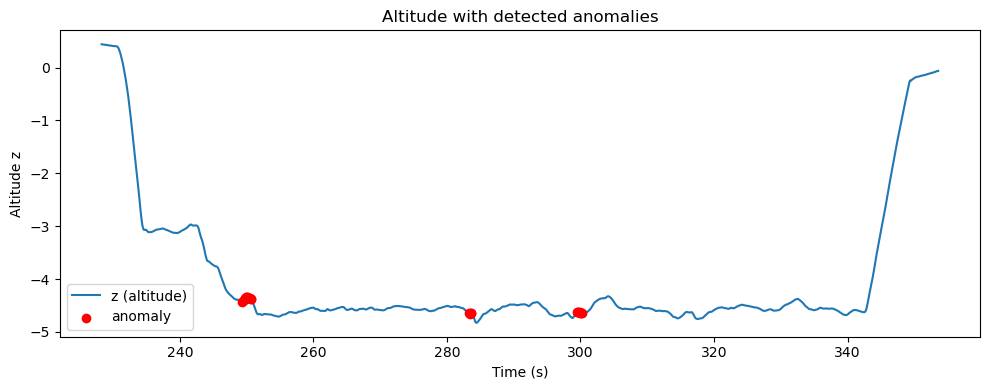

Saved anomaly results to: C:\Users\12162\Downloads\Drone_LOG_anomaly_results.csv


In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1) Set data directory
data_dir = Path("C:/Users/12162/Downloads")

# 2) Load attitude and local position logs
att = pd.read_csv(data_dir / "Drone LOG_vehicle_attitude_0.csv")
pos = pd.read_csv(data_dir / "Drone LOG_vehicle_local_position_0.csv")

print("Attitude columns:", att.columns.tolist())
print("Local position columns:", pos.columns.tolist())

# 3) Convert PX4 'timestamp' (microseconds) → seconds
for df in (att, pos):
    df['t'] = df['timestamp'] * 1e-6

# attitude already contains roll/pitch/yaw use them,
# otherwise convert quaternion q[0]=w, q[1]=x, q[2]=y, q[3]=z -> roll,pitch,yaw
if {'roll', 'pitch', 'yaw'}.issubset(att.columns):
    att = att[['t', 'roll', 'pitch', 'yaw']].sort_values('t')
else:
    # compute EULER from quaternion (assume q[0]=w, q[1]=x, q[2]=y, q[3]=z)
    w = att['q[0]'].to_numpy()
    x_q = att['q[1]'].to_numpy()
    y_q = att['q[2]'].to_numpy()
    z_q = att['q[3]'].to_numpy()

    t0 = +2.0 * (w * x_q + y_q * z_q)
    t1 = +1.0 - 2.0 * (x_q * x_q + y_q * y_q)
    roll = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y_q - z_q * x_q)
    t2 = np.clip(t2, -1.0, 1.0)
    pitch = np.arcsin(t2)

    t3 = +2.0 * (w * z_q + x_q * y_q)
    t4 = +1.0 - 2.0 * (y_q * y_q + z_q * z_q)
    yaw = np.arctan2(t3, t4)

    att = att.assign(roll=roll, pitch=pitch, yaw=yaw)[['t', 'roll', 'pitch', 'yaw']].sort_values('t')

pos = pos[['t', 'x', 'y', 'z', 'vx', 'vy', 'vz']].sort_values('t')

# 5) Merge streams by nearest timestamp (within 20ms)
df = pd.merge_asof(att, pos, on='t', direction='nearest', tolerance=0.02)
df = df.dropna().reset_index(drop=True)

print("Merged shape:", df.shape)
print(df.head())

# 6) Build sliding-window features (1-second window)
cols = ['roll', 'pitch', 'yaw', 'x', 'y', 'z', 'vx', 'vy', 'vz']

dt = df['t'].diff().median()
print("Median dt (s):", dt)

window_sec = 1.0
win = max(2, int(window_sec / dt))  # at least 2 samples

features = []
times = []

for i in range(win, len(df)):
    window = df.iloc[i-win:i]
    feats = []
    for c in cols:
        feats.extend([
            window[c].mean(),
            window[c].std(),
            window[c].min(),
            window[c].max(),
        ])
    features.append(feats)
    times.append(df['t'].iloc[i])

X = np.array(features)
t_feat = np.array(times)

print("Feature matrix shape:", X.shape)

# 7) Scale + train Isolation Forest (unsupervised anomaly detection)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(
    n_estimators=200,
    contamination=0.02,   # assume ~2% of windows are anomalous
    random_state=42
)
iso.fit(X_scaled)

scores = -iso.decision_function(X_scaled)  # higher = more anomalous
labels = iso.predict(X_scaled)             # 1 = normal, -1 = anomaly

# 8) Plot anomaly score over time
plt.figure(figsize=(10,4))
plt.plot(t_feat, scores)
plt.xlabel("Time (s)")
plt.ylabel("Anomaly score")
plt.title("UAV anomaly score over time")
plt.tight_layout()
plt.show()

# 9) Overlay anomalies on altitude (z)
anomaly_times = t_feat[labels == -1]
z_interp = np.interp(anomaly_times, df['t'], df['z'])

plt.figure(figsize=(10,4))
plt.plot(df['t'], df['z'], label="z (altitude)")
plt.scatter(anomaly_times, z_interp, color='red', label="anomaly", zorder=3)
plt.xlabel("Time (s)")
plt.ylabel("Altitude z")
plt.title("Altitude with detected anomalies")
plt.legend()
plt.tight_layout()
plt.show()

# 10) Save anomaly results (optional)
out = pd.DataFrame({
    't': t_feat,
    'anomaly_score': scores,
    'label': labels
})
out_path = data_dir / "Drone_LOG_anomaly_results.csv"
out.to_csv(out_path, index=False)
print("Saved anomaly results to:", out_path)


In [8]:
anomaly_indices = np.where(labels == -1)[0]
df.iloc[anomaly_indices].head()


,t,roll,pitch,yaw,x,y,z,vx,vy,vz
202,248.369923,-0.127239,0.153497,1.992990,-11.010440,10.330279,-4.386394,-1.784661,1.109061,-0.054087
203,248.470023,-0.106324,0.155395,2.071420,-11.186955,10.460927,-4.390097,-1.695513,1.005862,-0.079217
204,248.575222,-0.089790,0.163060,2.152251,-11.352830,10.584870,-4.387865,-1.555062,0.907771,-0.069073
205,248.669836,-0.076152,0.164981,2.206421,-11.491394,10.687402,-4.388735,-1.494067,0.840056,-0.133870
206,248.775116,-0.066464,0.182785,2.228104,-11.635038,10.787913,-4.398577,-1.371084,0.698306,-0.279443


In [9]:
imu_fft = pd.read_csv("C:/Users/12162/Downloads/Drone LOG_sensor_gyro_fft_0.csv")
imu_fft.head()


,timestamp,timestamp_sample,device_id,sensor_sample_rate_hz,resolution_hz,peak_frequencies_x[0],peak_frequencies_x[1],peak_frequencies_x[2],peak_frequencies_y[0],peak_frequencies_y[1],...,peak_frequencies_z[2],peak_snr_x[0],peak_snr_x[1],peak_snr_x[2],peak_snr_y[0],peak_snr_y[1],peak_snr_y[2],peak_snr_z[0],peak_snr_z[1],peak_snr_z[2]
0,229564591,229564062,2424842,9124.362,17.821020,77.94841,NaN,NaN,NaN,NaN,...,NaN,10.116897,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
1,229577721,229577146,2424842,9124.366,17.821028,90.68738,NaN,NaN,NaN,NaN,...,NaN,11.782139,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
2,229619923,229619263,2424842,9124.366,17.821028,101.20464,NaN,NaN,NaN,NaN,...,NaN,12.063260,NaN,NaN,0.0,0.0,0.0,10.686649,NaN,NaN
3,229667202,229666554,2424842,9124.366,17.821028,101.20464,NaN,NaN,NaN,NaN,...,NaN,10.788059,NaN,NaN,0.0,0.0,0.0,7.893148,NaN,NaN
4,229709219,229708646,2424842,9124.366,17.821028,102.85868,NaN,NaN,NaN,NaN,...,NaN,11.225902,NaN,NaN,0.0,0.0,0.0,9.004068,NaN,NaN


In [10]:
anomaly_idx = np.where(labels == -1)[0]
anomaly_times_sample = t_feat[anomaly_idx[:10]]
anomaly_times_sample


array([249.369493, 249.474784, 249.569855, 249.674624, 249.769339,
       249.874606, 249.974549, 250.069427, 250.174426, 250.269106])

In [11]:
# Generating agnostic anomoly window and scores

In [12]:
import numpy as np

# Indices of anomalous windows
anomaly_idx = np.where(labels == -1)[0]

# Sort anomalies by anomaly score (highest = most abnormal)
anomaly_scores = scores[anomaly_idx]
sorted_idx = anomaly_idx[np.argsort(-anomaly_scores)]

# Pick top N most anomalous windows
N = 3  # change to see more/less
top_anomaly_indices = sorted_idx[:N]
top_anomaly_times = t_feat[top_anomaly_indices]

top_anomaly_times


array([250.069427, 249.974549, 250.174426])

In [13]:
import matplotlib.pyplot as plt

def plot_anomaly_window(df, center_time, window=3.0):
    """
    Plot a multi-panel diagnostic view of signals around a given anomaly time.
    
    df: merged multimodal dataframe (with 't' and many sensor columns)
    center_time: time (in seconds) at center of anomaly window
    window: half-width in seconds (plots [t-window, t+window])
    """
    t0 = center_time - window
    t1 = center_time + window
    seg = df[(df['t'] >= t0) & (df['t'] <= t1)].copy()

    if seg.empty:
        print(f"No data for window around t={center_time:.3f}")
        return

    # Define groups of signals to plot if they exist
    groups = [
        (['roll', 'pitch', 'yaw'],            "Attitude (rad)"),
        (['x', 'y', 'z'],                     "Position (m)"),
        (['vx', 'vy', 'vz'],                  "Velocity (m/s)"),
        (['ax', 'ay', 'az'],                  "IMU Accel (m/s²)"),
        (['gx', 'gy', 'gz'],                  "IMU Gyro (rad/s)"),
        (['voltage_v', 'current_a'],          "Battery"),
    ]

    # Add actuator outputs dynamically (first 4)
    motor_cols = [c for c in df.columns if c.startswith('output[')]
    motor_cols = sorted(motor_cols)[:4]
    if motor_cols:
        groups.append((motor_cols, "Motor outputs"))

    # Filter out groups that don't exist in this df
    valid_groups = []
    for cols, title in groups:
        existing = [c for c in cols if c in df.columns]
        if existing:
            valid_groups.append((existing, title))

    n_groups = len(valid_groups)
    if n_groups == 0:
        print("No known signals to plot in df.")
        return

    fig, axes = plt.subplots(n_groups, 1, figsize=(10, 2.5 * n_groups), sharex=True)
    if n_groups == 1:
        axes = [axes]

    for ax, (cols, title) in zip(axes, valid_groups):
        for c in cols:
            ax.plot(seg['t'], seg[c], label=c)
        ax.axvline(center_time, linestyle='--')  # mark anomaly center
        ax.set_ylabel(title)
        ax.legend(loc='best', fontsize=8)
        ax.grid(True)

    axes[-1].set_xlabel("Time (s)")
    fig.suptitle(f"Anomaly window around t = {center_time:.3f} s", y=0.98)
    plt.tight_layout()
    plt.show()


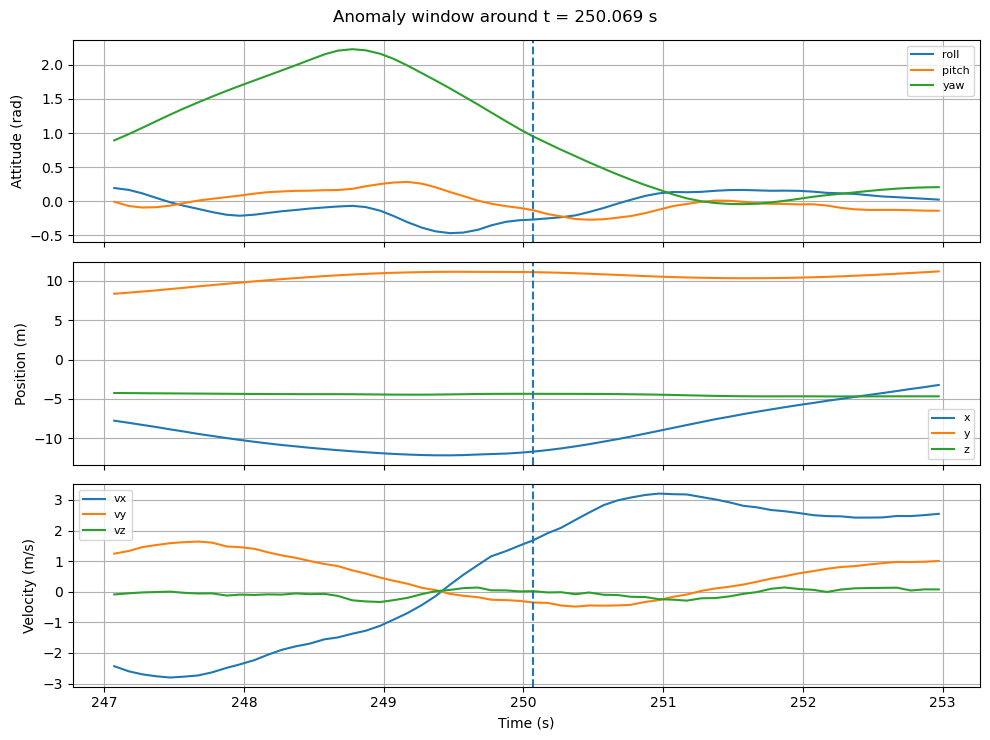

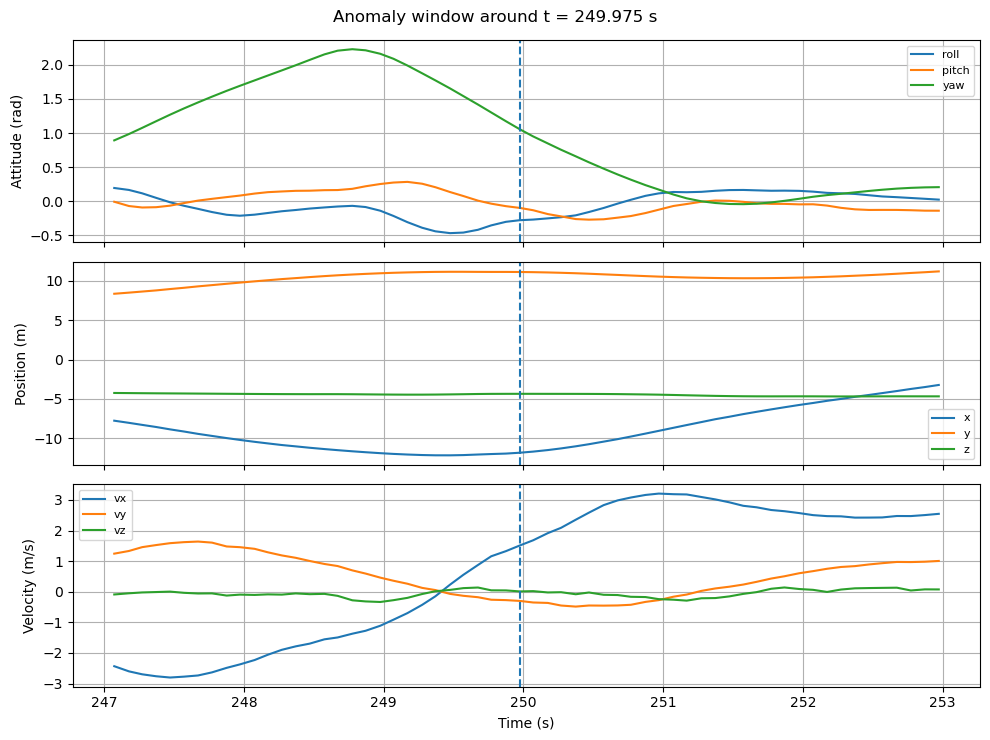

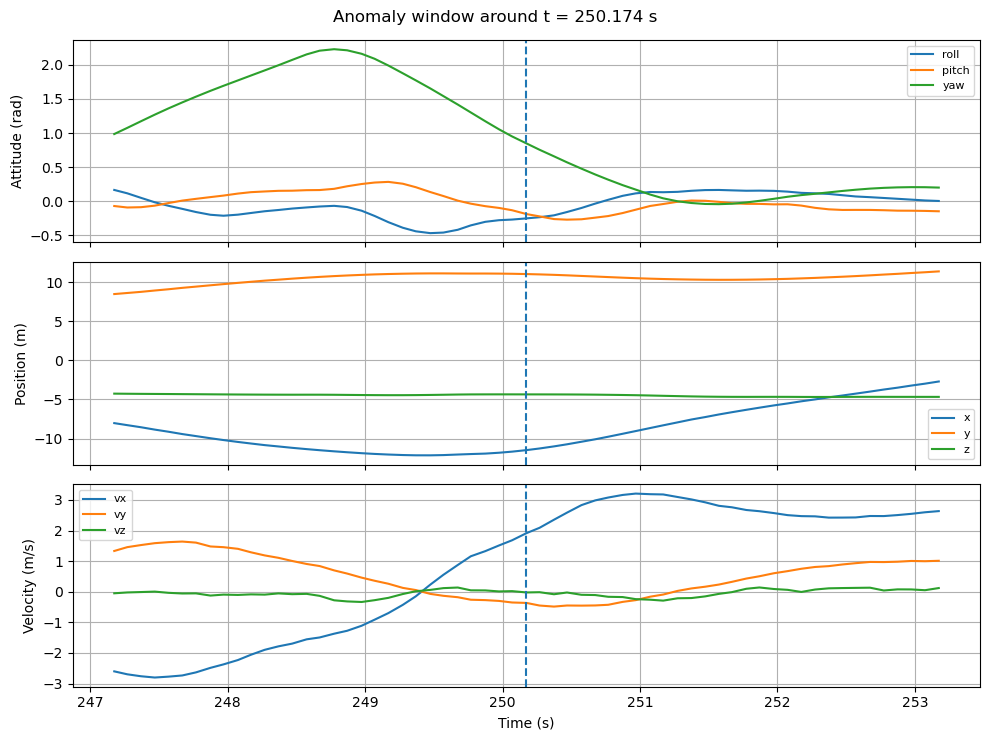

In [14]:
for t_anom in top_anomaly_times:
    plot_anomaly_window(df, center_time=t_anom, window=3.0)


In [15]:
%pip install ffmpeg-python

Note: you may need to restart the kernel to use updated packages.


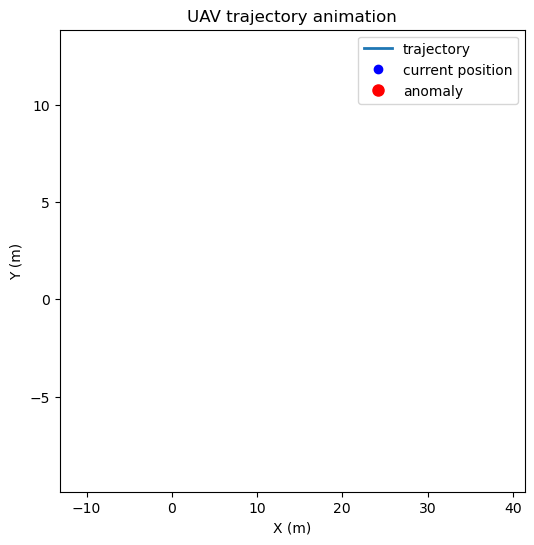

C:\Users\12162\AppData\Local\Temp\ipykernel_42496\488512500.py:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(x[-1], y[-1])
C:\Users\12162\AppData\Local\Temp\ipykernel_42496\488512500.py:50: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  anom_point.set_data(x[-1], y[-1])


Saved animation to: uav_trajectory_anomaly.gif


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Use only rows that have x,y
traj = df[['t', 'x', 'y']].dropna().reset_index(drop=True)

# If you have anomaly_times in a different time base, you can skip this
anom_times = np.array(anomaly_times)

# Figure setup
fig, ax = plt.subplots(figsize=(6, 6))
line, = ax.plot([], [], lw=2, label="trajectory")
point, = ax.plot([], [], 'bo', label="current position")
anom_point, = ax.plot([], [], 'ro', markersize=8, label="anomaly")
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_title("UAV trajectory animation")
ax.legend()

# Set plot limits a bit bigger than data range
ax.set_xlim(traj['x'].min() - 1, traj['x'].max() + 1)
ax.set_ylim(traj['y'].min() - 1, traj['y'].max() + 1)

def init():
    line.set_data([], [])
    point.set_data([], [])
    anom_point.set_data([], [])
    time_text.set_text('')
    return line, point, anom_point, time_text

def update(frame):
    # Up to current frame
    sub = traj.iloc[:frame+1]
    x = sub['x'].values
    y = sub['y'].values
    t = sub['t'].values[-1]

    # Draw path and current position
    line.set_data(x, y)
    point.set_data(x[-1], y[-1])
    time_text.set_text(f"t = {t:.2f} s")

    # Check if current time is near an anomaly
    if len(anom_times) > 0:
        idx = np.argmin(np.abs(anom_times - t))
        if np.abs(anom_times[idx] - t) < 0.2:  # within 0.2s of an anomaly
            anom_point.set_data(x[-1], y[-1])
        else:
            anom_point.set_data([], [])
    else:
        anom_point.set_data([], [])

    return line, point, anom_point, time_text

ani = FuncAnimation(
    fig,
    update,
    frames=len(traj),
    init_func=init,
    blit=True,
    interval=40  # ms between frames (~25 fps)
)

plt.show()   # will play inline in Jupyter

# Save animation as GIF using Pillow (avoids needing FFmpeg system binary).
# If you really need MP4, install a system FFmpeg binary or use imageio/imageio-ffmpeg.
try:
    from matplotlib.animation import PillowWriter
    writer = PillowWriter(fps=25)
    ani.save("uav_trajectory_anomaly.gif", writer=writer)
    print("Saved animation to: uav_trajectory_anomaly.gif")
except Exception as e:
    print("Could not save animation:", e)